In [9]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = lf_samples[::10]  # sample every 5 points
# hf_samples = torch.linspace(0.0, 1.0, 21).reshape(-1, 1)

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)

In [11]:
# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

# dataset of lf1 and hf
responses_lf1 = {"lf": lf1_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf2 = {"lf": lf2_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf3 = {"lf": lf3_responses,
                 "hf": hf_responses}

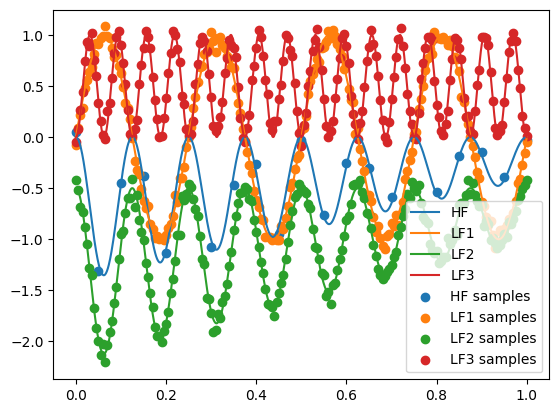

In [12]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless, label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless, label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless, label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
plt.legend()
plt.show()

In [13]:
# correlation between HF and LF samples
print("Correlation between HF and LF samples")
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf1_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf2_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf3_responses_noiseless.flatten()))

Correlation between HF and LF samples
PearsonRResult(statistic=-0.10188648995412593, pvalue=0.0012469388228371753)
PearsonRResult(statistic=0.9999999999999967, pvalue=0.0)
PearsonRResult(statistic=-0.0017524227898377388, pvalue=0.9558397582437065)


## Configurations for DNN and BNNs


In [14]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 30000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [15]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

epoch:     0/20000
nll_loss: 637.775, prior_loss: 2507.352, total: 3145.127
noise: 0.123
epoch:   100/20000
nll_loss: 553.719, prior_loss: 2716.400, total: 3270.119
noise: 0.123
epoch:   200/20000
nll_loss: 548.317, prior_loss: 2822.209, total: 3370.526
noise: 0.123
epoch:   300/20000
nll_loss: 545.538, prior_loss: 2909.246, total: 3454.784
noise: 0.123
epoch:   400/20000
nll_loss: 547.654, prior_loss: 2975.051, total: 3522.704
noise: 0.123
epoch:   500/20000
nll_loss: 546.171, prior_loss: 3056.058, total: 3602.229
noise: 0.123
epoch:   600/20000
nll_loss: 541.990, prior_loss: 3119.077, total: 3661.066
noise: 0.123
epoch:   700/20000
nll_loss: 540.543, prior_loss: 3161.421, total: 3701.965
noise: 0.123
epoch:   800/20000
nll_loss: 539.897, prior_loss: 3233.324, total: 3773.221
noise: 0.123
epoch:   900/20000
nll_loss: 540.556, prior_loss: 3307.220, total: 3847.776
noise: 0.123
epoch:  1000/20000
nll_loss: 542.577, prior_loss: 3348.852, total: 3891.429
noise: 0.123
epoch:  1100/20000
nl

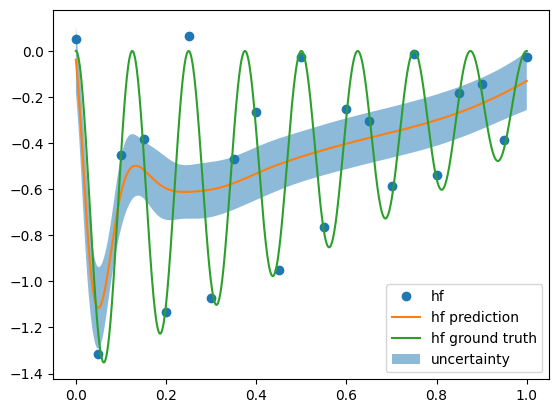

In [16]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [17]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.961838960647583
epoch:  200 train loss:  0.9615093469619751
epoch:  300 train loss:  0.9610196948051453
epoch:  400 train loss:  0.9600834846496582
epoch:  500 train loss:  0.9573500752449036
epoch:  600 train loss:  0.9317362904548645
epoch:  700 train loss:  0.8788072466850281
epoch:  800 train loss:  0.774040699005127
epoch:  900 train loss:  0.5667928457260132
epoch:  1000 train loss:  0.41882362961769104
epoch:  1100 train loss:  0.18053200840950012
epoch:  1200 train loss:  0.03186018764972687
epoch:  1300 train loss:  0.022422347217798233
epoch:  1400 train loss:  0.018955307081341743
epoch:  1500 train loss:  0.015948543325066566
epoch:  1600 train loss:  0.012721856124699116
epoch:  1700 train loss:  0.009958728216588497
epoch:  1800 train loss:  0.008122415281832218
epoch:  1900 train loss:  0.006926903035491705
epoch:  2000 train loss:  0.00610616197809577
epoch:  2100 train loss:  0.005551440641283989
epoch

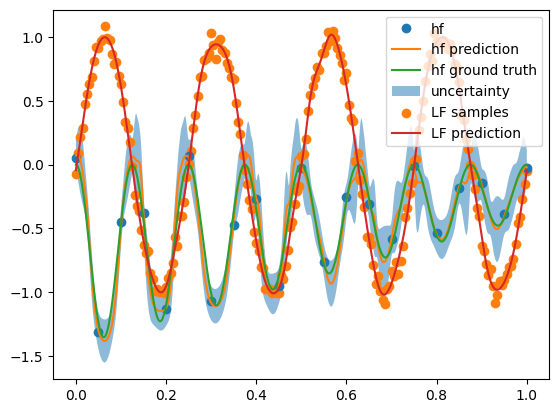

In [18]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [19]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9622323513031006
epoch:  200 train loss:  0.9615445733070374
epoch:  300 train loss:  0.9600943922996521
epoch:  400 train loss:  0.9481750726699829
epoch:  500 train loss:  0.8906702399253845
epoch:  600 train loss:  0.7687416076660156
epoch:  700 train loss:  0.5448369979858398
epoch:  800 train loss:  0.304442822933197
epoch:  900 train loss:  0.05492277443408966
epoch:  1000 train loss:  0.019224774092435837
epoch:  1100 train loss:  0.014009926468133926
epoch:  1200 train loss:  0.010230316780507565
epoch:  1300 train loss:  0.00739585654810071
epoch:  1400 train loss:  0.005752049386501312
epoch:  1500 train loss:  0.00502424594014883
epoch:  1600 train loss:  0.0047371587716042995
epoch:  1700 train loss:  0.004614161793142557
epoch:  1800 train loss:  0.004548235330730677
epoch:  1900 train loss:  0.004503876902163029
epoch:  2000 train loss:  0.0044744363985955715
epoch:  2100 train loss:  0.004442469216883182

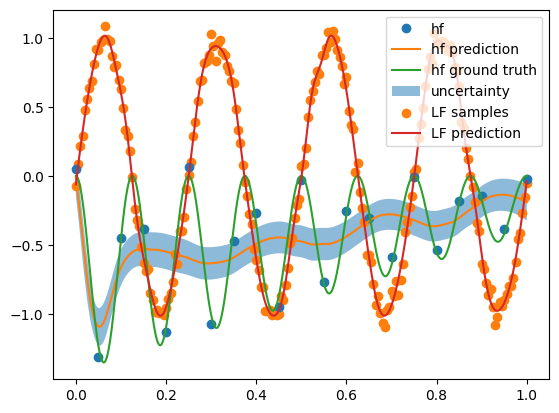

In [20]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

In [59]:
# mf-dnn-bnn with different orders
mfdnnbnn_lf1_order_2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure={
        "in_features": 1,
        "hidden_features": [100, 100],
        "out_features": 1,
        "activation": "Tanh",
        "lr": 0.001,
        "sigma": 0.05,
    },
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)

# train the model
mfdnnbnn_lf1_order_2.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config={
        "num_epochs": 20000,
        "sample_freq": 100,
        "print_info": True,
        "burn_in_epochs": 10000,
    },
)

No data split: use all data for training
epoch:  100 train loss:  0.9617981314659119
epoch:  200 train loss:  0.9609900116920471
epoch:  300 train loss:  0.9550937414169312
epoch:  400 train loss:  0.8903403878211975
epoch:  500 train loss:  0.8292478322982788
epoch:  600 train loss:  0.6907981038093567
epoch:  700 train loss:  0.5553991794586182
epoch:  800 train loss:  0.4448520541191101
epoch:  900 train loss:  0.16652101278305054
epoch:  1000 train loss:  0.029502825811505318
epoch:  1100 train loss:  0.016348985955119133
epoch:  1200 train loss:  0.011018539778888226
epoch:  1300 train loss:  0.007816851139068604
epoch:  1400 train loss:  0.0064260526560246944
epoch:  1500 train loss:  0.005890293046832085
epoch:  1600 train loss:  0.00557538541033864
epoch:  1700 train loss:  0.005346613936126232
epoch:  1800 train loss:  0.0051711080595850945
epoch:  1900 train loss:  0.0050256322138011456
epoch:  2000 train loss:  0.004909859504550695
epoch:  2100 train loss:  0.004813919775187

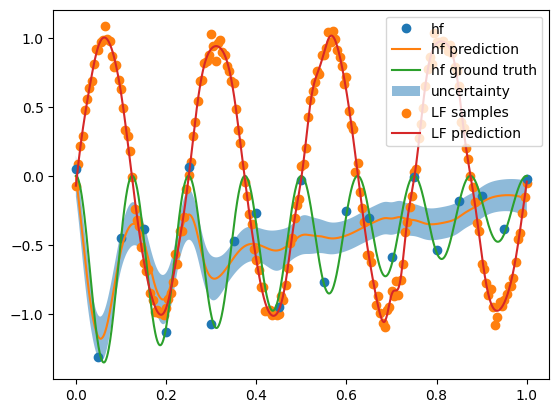

In [60]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_order_2_hy,
    mfdnnbnn_lf1_order_2_epistemic,
    mfdnnbnn_lf1_order_2_total_unc,
    mfdnnbnn_lf1_order_2_aleatoric,
) = mfdnnbnn_lf1_order_2.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_order_2_y = mfdnnbnn_lf1_order_2.predict_lf(
    x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(),
        mfdnnbnn_lf1_order_2_y,
        label="LF prediction")
ax.legend()
plt.show()

In [58]:
mfdnnbnn_lf1_order_2.beta

array([ 0.02558623, -0.07763464, -0.9756891 ])

## mf models for the second dataset

In [23]:
# sequential mf-bnn
smf_bnn_lf2 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8465858101844788
epoch:  200 train loss:  0.8464574217796326
epoch:  300 train loss:  0.846332311630249
epoch:  400 train loss:  0.8462233543395996
epoch:  500 train loss:  0.8461353778839111
epoch:  600 train loss:  0.846067488193512
epoch:  700 train loss:  0.8460168242454529
epoch:  800 train loss:  0.8459791541099548
epoch:  900 train loss:  0.8459495306015015
epoch:  1000 train loss:  0.845923662185669
epoch:  1100 train loss:  0.8458976149559021
epoch:  1200 train loss:  0.8458687663078308
epoch:  1300 train loss:  0.8458344340324402
epoch:  1400 train loss:  0.8457927703857422
epoch:  1500 train loss:  0.8457390069961548
epoch:  1600 train loss:  0.8456636667251587
epoch:  1700 train loss:  0.8455396890640259
epoch:  1800 train loss:  0.845282256603241
epoch:  1900 train loss:  0.8447064161300659
epoch:  2000 train loss:  0.8437040448188782
epoch:  2100 train loss:  0.8418465256690979
epoch:  2200 train loss:  0

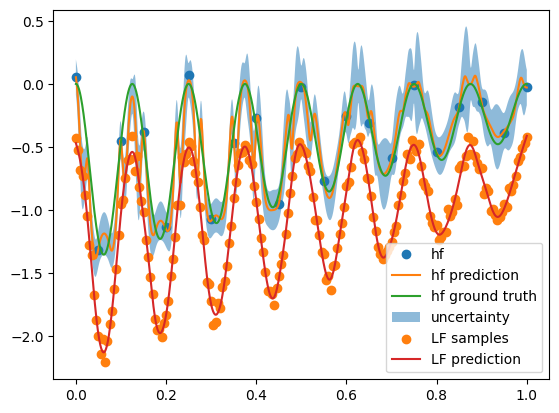

In [24]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf2_hy,
    smf_bnn_lf2_epistemic,
    smf_bnn_lf2_total_unc,
    smf_bnn_lf2_aleatoric,
) = smf_bnn_lf2.predict(x=test_samples)
# get lf predictions
smf_bnn_lf2_y = smf_bnn_lf2.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [25]:
# create the MFDNNBNN object
mfdnnbnn_lf2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8468334078788757
epoch:  200 train loss:  0.8464771509170532
epoch:  300 train loss:  0.8462022542953491
epoch:  400 train loss:  0.8460149168968201
epoch:  500 train loss:  0.8459029197692871
epoch:  600 train loss:  0.8458353877067566
epoch:  700 train loss:  0.8457694053649902
epoch:  800 train loss:  0.8456687331199646
epoch:  900 train loss:  0.8454561829566956
epoch:  1000 train loss:  0.8449321389198303
epoch:  1100 train loss:  0.8439844250679016
epoch:  1200 train loss:  0.8426460027694702
epoch:  1300 train loss:  0.8397016525268555
epoch:  1400 train loss:  0.8284991979598999
epoch:  1500 train loss:  0.7524610757827759
epoch:  1600 train loss:  0.6910198330879211
epoch:  1700 train loss:  0.6700217723846436
epoch:  1800 train loss:  0.6599329710006714
epoch:  1900 train loss:  0.6218122243881226
epoch:  2000 train loss:  0.5591295957565308
epoch:  2100 train loss:  0.4871170222759247
epoch:  2200 train loss

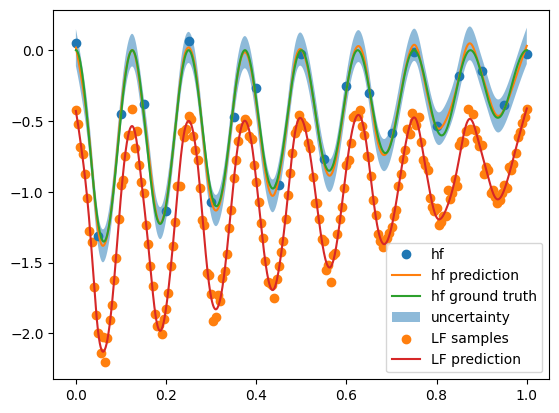

In [26]:
(
    hy_proposed_lf2,
    epistemic_proposed_lf2,
    total_unc_proposed_lf2,
    aleatoric_proposed_lf2,
) = mfdnnbnn_lf2.predict(x=test_samples)
# lf prediction
lf2_y_proposed = mfdnnbnn_lf2.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf2_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

## for datset 3

In [27]:
# sequential mf-bnn
smf_bnn_lf3 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9949700832366943
epoch:  200 train loss:  0.9948117733001709
epoch:  300 train loss:  0.9946604371070862
epoch:  400 train loss:  0.9945939183235168
epoch:  500 train loss:  0.9945802688598633
epoch:  600 train loss:  0.994569718837738
epoch:  700 train loss:  0.9945617914199829
epoch:  800 train loss:  0.9945433735847473
epoch:  900 train loss:  0.9945264458656311
epoch:  1000 train loss:  0.9945033192634583
epoch:  1100 train loss:  0.9944708347320557
epoch:  1200 train loss:  0.9944130182266235
epoch:  1300 train loss:  0.9942944049835205
epoch:  1400 train loss:  0.9940022230148315
epoch:  1500 train loss:  0.9934061765670776
epoch:  1600 train loss:  0.9923145174980164
epoch:  1700 train loss:  0.9905614852905273
epoch:  1800 train loss:  0.9869884252548218
epoch:  1900 train loss:  0.9806568622589111
epoch:  2000 train loss:  0.9726526737213135
epoch:  2100 train loss:  0.9622427821159363
epoch:  2200 train loss:

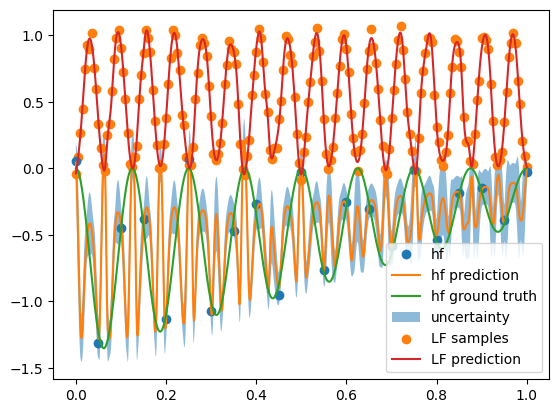

In [28]:
# plot
(
    smf_bnn_lf3_hy,
    smf_bnn_lf3_epistemic,
    smf_bnn_lf3_total_unc,
    smf_bnn_lf3_aleatoric,
) = smf_bnn_lf3.predict(x=test_samples)
# get lf predictions
smf_bnn_lf3_y = smf_bnn_lf3.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [29]:
# create the MFDNNBNN object
mfdnnbnn_lf3 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9950056672096252
epoch:  200 train loss:  0.9948551058769226
epoch:  300 train loss:  0.9947254657745361
epoch:  400 train loss:  0.9946523904800415
epoch:  500 train loss:  0.9946245551109314
epoch:  600 train loss:  0.9946104884147644
epoch:  700 train loss:  0.994598925113678
epoch:  800 train loss:  0.9945874810218811
epoch:  900 train loss:  0.9945744872093201
epoch:  1000 train loss:  0.9945573806762695
epoch:  1100 train loss:  0.9945329427719116
epoch:  1200 train loss:  0.9944946765899658
epoch:  1300 train loss:  0.9944310188293457
epoch:  1400 train loss:  0.9943215250968933
epoch:  1500 train loss:  0.9941401481628418
epoch:  1600 train loss:  0.993861734867096
epoch:  1700 train loss:  0.9934534430503845
epoch:  1800 train loss:  0.9928646683692932
epoch:  1900 train loss:  0.9920023679733276
epoch:  2000 train loss:  0.9906655550003052
epoch:  2100 train loss:  0.9884870052337646
epoch:  2200 train loss: 

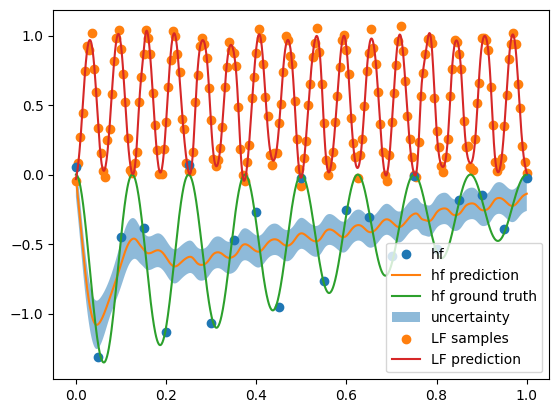

In [30]:
# predict
(
    hy_proposed_lf3,
    epistemic_proposed_lf3,
    total_unc_proposed_lf3,
    aleatoric_proposed_lf3,
) = mfdnnbnn_lf3.predict(x=test_samples)
# lf prediction
lf3_y_proposed = mfdnnbnn_lf3.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf3_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [31]:
# print the beta values
print("Beta values")
print(mfdnnbnn_lf1.beta)
print(mfdnnbnn_lf1_order_2.beta)
print(mfdnnbnn_lf2.beta)
print(mfdnnbnn_lf3.beta)

Beta values
[-0.43601392 -0.07481716]
[ 0.03556709 -0.07491205 -1.01385614]
[0.42628075 0.8488202 ]
[-0.40092073 -0.07316383]


In [32]:
# evaluate the models on the accuracy metrics
# bnn model
# calculate the mse
import pandas as pd
bnn_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), bnn_y, bnn_total_unc)
bnn_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), bnn_y)
# print the results
print("BNN model")
print(f"Normalized RMSE: {bnn_mse}")
print(f"Normalized MAE: {bnn_nmae}")
print(f"Normalized Log Likelihood: {bnn_nll}")
print(f"R2: {bnn_r2}")

# sequential mf-bnn on lf1
# calculate the mse
smf_bnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy, smf_bnn_lf1_total_unc)
smf_bnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
# print the results
print("Sequential MF-BNN on LF1")
print(f"Normalized RMSE: {smf_bnn_lf1_mse}")
print(f"Normalized MAE: {smf_bnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf1_nll}")
print(f"R2: {smf_bnn_lf1_r2}")

# mf-dnn-bnn on lf1
# calculate the mse
mfdnnbnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy, mfdnnbnn_lf1_total_unc)
mfdnnbnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
# print the results
print("MF-DNN-BNN on LF1")
print(f"Normalized RMSE: {mfdnnbnn_lf1_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_nll}")

# mf-dnn-bnn on lf1 with order 2
# calculate the mse
mfdnnbnn_lf1_order_2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy, mfdnnbnn_lf1_order_2_total_unc)
mfdnnbnn_lf1_order_2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
# print the results
print("MF-DNN-BNN on LF1 with order 2")
print(f"Normalized RMSE: {mfdnnbnn_lf1_order_2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_order_2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_order_2_nll}")
print(f"R2: {mfdnnbnn_lf1_order_2_r2}")


# sequential mf-bnn on lf2
# calculate the mse
smf_bnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy, smf_bnn_lf2_total_unc)
smf_bnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
# print the results
print("Sequential MF-BNN on LF2")
print(f"Normalized RMSE: {smf_bnn_lf2_mse}")
print(f"Normalized MAE: {smf_bnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf2_nll}")
print(f"R2: {smf_bnn_lf2_r2}")

# mf-dnn-bnn on lf2
# calculate the mse
mfdnnbnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2, total_unc_proposed_lf2)
mfdnnbnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
# print the results
print("MF-DNN-BNN on LF2")
print(f"Normalized RMSE: {mfdnnbnn_lf2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf2_nll}")
print(f"R2: {mfdnnbnn_lf2_r2}")

# sequential mf-bnn on lf3
# calculate the mse
smf_bnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy, smf_bnn_lf3_total_unc)
smf_bnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)

# print the results
print("Sequential MF-BNN on LF3")
print(f"Normalized RMSE: {smf_bnn_lf3_mse}")
print(f"Normalized MAE: {smf_bnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf3_nll}")
print(f"R2: {smf_bnn_lf3_r2}")

# mf-dnn-bnn on lf3
# calculate the mse
mfdnnbnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3, total_unc_proposed_lf3)
mfdnnbnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
# print the results
print("MF-DNN-BNN on LF3")
print(f"Normalized RMSE: {mfdnnbnn_lf3_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf3_nll}")
print(f"R2: {mfdnnbnn_lf3_r2}")

# save the results in pandas dataframe
results = {
    "Model": ["BNN", "Sequential MF-BNN LF1", "MF-DNN-BNN LF1",
              "MF-DNN-BNN LF1 Order 2", "Sequential MF-BNN LF2",
              "MF-DNN-BNN LF2", "Sequential MF-BNN LF3", "MF-DNN-BNN LF3"],
    "Normalized RMSE": [bnn_mse, smf_bnn_lf1_mse, mfdnnbnn_lf1_mse,
                        mfdnnbnn_lf1_order_2_mse, smf_bnn_lf2_mse,
                        mfdnnbnn_lf2_mse, smf_bnn_lf3_mse, mfdnnbnn_lf3_mse],
    "Normalized MAE": [bnn_nmae, smf_bnn_lf1_nmae, mfdnnbnn_lf1_nmae,
                       mfdnnbnn_lf1_order_2_nmae, smf_bnn_lf2_nmae,
                       mfdnnbnn_lf2_nmae, smf_bnn_lf3_nmae, mfdnnbnn_lf3_nmae],
    "Normalized Log Likelihood": [bnn_nll, smf_bnn_lf1_nll, mfdnnbnn_lf1_nll,
                                  mfdnnbnn_lf1_order_2_nll, smf_bnn_lf2_nll,
                                  mfdnnbnn_lf2_nll, smf_bnn_lf3_nll, mfdnnbnn_lf3_nll],
    "R2": [bnn_r2, smf_bnn_lf1_r2, mfdnnbnn_lf1_r2,
           mfdnnbnn_lf1_order_2_r2, smf_bnn_lf2_r2,
           mfdnnbnn_lf2_r2, smf_bnn_lf3_r2, mfdnnbnn_lf3_r2],
}
results_df = pd.DataFrame(results)
print(results_df)

BNN model
Normalized RMSE: 0.6737913489341736
Normalized MAE: 1.4157413244247437
Normalized Log Likelihood: -11.380370140075684
R2: 0.30093534240505415
Sequential MF-BNN on LF1
Normalized RMSE: 0.1670360416173935
Normalized MAE: 0.5068090558052063
Normalized Log Likelihood: 1.110852837562561
R2: 0.957037761367563
MF-DNN-BNN on LF1
Normalized RMSE: 0.6892696619033813
Normalized MAE: 1.5053762197494507
Normalized Log Likelihood: -12.112691879272461
MF-DNN-BNN on LF1 with order 2
Normalized RMSE: 0.6956171989440918
Normalized MAE: 1.5152292251586914
Normalized Log Likelihood: -12.570369720458984
R2: 0.2549127612682489
Sequential MF-BNN on LF2
Normalized RMSE: 0.35634586215019226
Normalized MAE: 1.3598368167877197
Normalized Log Likelihood: 0.6215366721153259
R2: 0.8044715778312639
MF-DNN-BNN on LF2
Normalized RMSE: 0.06133243069052696
Normalized MAE: 0.1641756147146225
Normalized Log Likelihood: 1.8186297416687012
R2: 0.9942077564136609
Sequential MF-BNN on LF3
Normalized RMSE: 0.89975279

In [33]:
results_df

,Model,Normalized RMSE,Normalized MAE,Normalized Log Likelihood,R2
0,BNN,0.673791,1.415741,-11.380370,0.300935
1,Sequential MF-BNN LF1,0.167036,0.506809,1.110853,0.957038
2,MF-DNN-BNN LF1,0.689270,1.505376,-12.112692,0.268449
3,MF-DNN-BNN LF1 Order 2,0.695617,1.515229,-12.570370,0.254913
4,Sequential MF-BNN LF2,0.356346,1.359837,0.621537,0.804472
5,MF-DNN-BNN LF2,0.061332,0.164176,1.818630,0.994208
6,Sequential MF-BNN LF3,0.899753,3.184101,-8.937283,-0.246559
7,MF-DNN-BNN LF3,0.680885,1.487639,-11.920900,0.286139


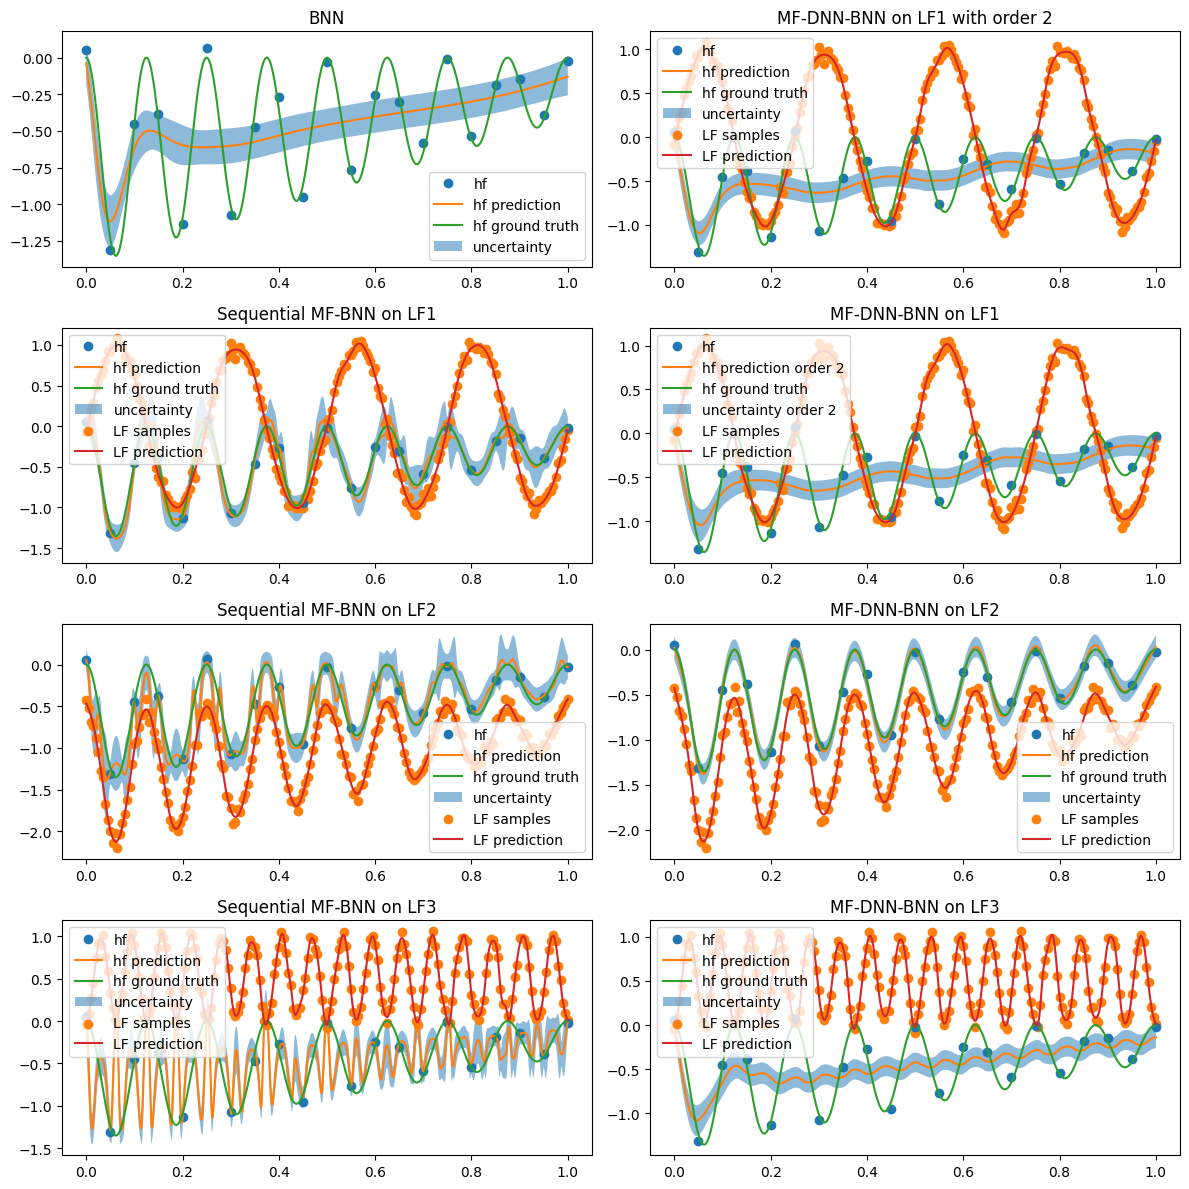

In [34]:
# plot the prediction of the models into one figure where the first row is the
# prediction of bnn (with one subfigure), and the second row is the prediction of sequential mf-bnn mf-dnn-bnn on lf1 (with two subfigures)
# the third row is the prediction of sequential mf-bnn mf-dnn-bnn on lf2 (with two subfigures)
# the forth row is the prediction of sequential mf-bnn mf-dnn-bnn on lf3  (with two subfigures)
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# plot the prediction of bnn
axs[0, 0].plot(hf_samples, hf_responses, "o", label="hf")
axs[0, 0].plot(test_samples.numpy(), bnn_y, label="hf prediction")
axs[0, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[0, 0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[0, 0].legend()
axs[0, 0].set_title("BNN")

# plot the prediction of mf-dnn-bnn on lf1 with order1
axs[0, 1].plot(hf_samples, hf_responses, "o", label="hf")
axs[0, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
axs[0, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[0, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

axs[0, 1].scatter(lf_samples, lf1_responses, label="LF samples")
axs[0, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_order_2_y,
    label="LF prediction"
)

axs[0, 1].legend()
axs[0, 1].set_title("MF-DNN-BNN on LF1 with order 2")


# plot the prediction of sequential mf-bnn on lf1
axs[1, 0].plot(hf_samples, hf_responses, "o", label="hf")
axs[1, 0].plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
axs[1, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[1, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[1, 0].scatter(lf_samples, lf1_responses, label="LF samples")
axs[1, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
axs[1, 0].legend()
axs[1, 0].set_title("Sequential MF-BNN on LF1")

# plot the prediction of mf-dnn-bnn on lf1
axs[1, 1].plot(hf_samples, hf_responses, "o", label="hf")
# with lf order 2
axs[1, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy,
               label="hf prediction order 2")
axs[1, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# with lf order 2
axs[1, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty order 2",
)
axs[1, 1].scatter(lf_samples, lf1_responses, label="LF samples")
axs[1, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_y,
    label="LF prediction"
)
axs[1, 1].legend()
axs[1, 1].set_title("MF-DNN-BNN on LF1")
# plot the prediction of sequential mf-bnn on lf2
axs[2, 0].plot(hf_samples, hf_responses, "o", label="hf")
axs[2, 0].plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
axs[2, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[2, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf2_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[2, 0].scatter(lf_samples, lf2_responses, label="LF samples")
axs[2, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
axs[2, 0].legend()
axs[2, 0].set_title("Sequential MF-BNN on LF2")

# plot the prediction of mf-dnn-bnn on lf2
axs[2, 1].plot(hf_samples, hf_responses, "o", label="hf")
axs[2, 1].plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
axs[2, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[2, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[2, 1].scatter(lf_samples, lf2_responses, label="LF samples")
axs[2, 1].plot(
    test_samples.numpy(),
    lf2_y_proposed.detach().numpy(),
    label="LF prediction"
)
axs[2, 1].legend()
axs[2, 1].set_title("MF-DNN-BNN on LF2")

# plot the prediction of sequential mf-bnn on lf3
axs[3, 0].plot(hf_samples, hf_responses, "o", label="hf")
axs[3, 0].plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
axs[3, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[3, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[3, 0].scatter(lf_samples, lf3_responses, label="LF samples")
axs[3, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
axs[3, 0].legend()
axs[3, 0].set_title("Sequential MF-BNN on LF3")


# plot the prediction of mf-dnn-bnn on lf3
axs[3, 1].plot(hf_samples, hf_responses, "o", label="hf")
axs[3, 1].plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
axs[3, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
axs[3, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
axs[3, 1].scatter(lf_samples, lf3_responses, label="LF samples")
axs[3, 1].plot(
    test_samples.numpy(),
    lf3_y_proposed.detach().numpy(),
    label="LF prediction"
)
axs[3, 1].legend()
axs[3, 1].set_title("MF-DNN-BNN on LF3")

plt.tight_layout()
plt.show()